In [1]:
import requests, zipfile, io
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import numpy as np
from scipy.optimize import curve_fit

In [ ]:
#this will download all the national oil & gas gateway data and extract them to csv files in a folder called "raw data"
#dont need to run this cell unless refreshing master data
zip_file_url = 'http://api.noggateway.org/report/all'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path='raw_data')

In [2]:
#this should be the path from where this notebook is saved to the raw data folder with where it was imported
path = 'raw_data'
file_names = os.listdir(path)

In [ ]:
#this makes a master dataframe called master_well_details_df that combiles all of the well information from the raw csv data
#dont need to run this cell unless refreshing master data
master_well_details_df = pd.DataFrame()
for i in file_names:
    if 'Well_Details' in i:
        master_well_details_df = master_well_details_df.append(pd.read_csv(f'{path}/{i}'))

#saving it to a pickle, in a folder called pickles for future ease of use
master_well_details_df.to_pickle('pickles/master_well_details_df.pkl')

In [88]:
master_well_details_df = pd.read_pickle('pickles/master_well_details_df.pkl')

In [5]:
#seeing the data that is available and what to filter the master dataframe out on
print(master_well_details_df.columns.tolist())
print(set(master_well_details_df['STANDARD WELL TYPE DESCRIPTION']))
print(set(master_well_details_df['DRILLING ORIENTATION']))

{'Underground Injection Control:Class 1', 'Underground Injection Control:Class 3', 'Oil and Gas', 'Permit', 'Underground Injection Control:Class 5', 'Oil', 'Unassigned', 'Underground Injection Control:Class 2 Enhanced Recovery', 'Coal Bed Methane', 'Water Supply', 'Dry Hole', 'Other', 'Gas', 'Underground Injection Control:Class 2 Disposal', 'Underground Injection Control:Class 2', 'Brine Supply', 'Unknown', 'Abandoned', 'Gas Storage', 'Observation Monitor Strat Test'}


In [89]:
#filtering for horizontal wells then deleting the master dataframe from memory
#dont need to run this cell unless refreshing master data
horizontal_wells_df = master_well_details_df.loc[master_well_details_df['DRILLING ORIENTATION'] == 'Horizontal']
del master_well_details_df

#filtering the horizontal wells for just oil, gas, and oil&gas wells
target_types = ['Oil', 'Gas', 'Oil and Gas']
horizontal_wells_df = horizontal_wells_df[horizontal_wells_df['STANDARD WELL TYPE DESCRIPTION'].isin(target_types)]

#saving the filtered df to a pickle for future use
horizontal_wells_df.to_pickle('pickles/horizontal_wells_df.pkl')

#saving the filtered api numbers to a list, then to a pickle
filtered_api_numbers = horizontal_wells_df['API NUMBER'].values.tolist()

In [31]:
#reading through the production data pdfs to pick out the the production data for the filtered apis
#dont need to run this cell unless refreshing filtered apis data
#this will take approx 10 minutes
master_well_production_df = pd.DataFrame()
for i in tqdm(file_names):
    if 'Production' in i:
        master_well_production_df = master_well_production_df.append(pd.read_csv(f'{path}/{i}'))
        master_well_production_df = master_well_production_df[master_well_production_df['API NUMBER'].isin(filtered_api_numbers)]
        print(len(master_well_production_df))

316
25620
123637
133109
133128
133784
134021
154714
155877
159113
159341
159596
177978
179588
179663
179731
191533
198529
208945
209205
209376
216105
220083
220200
313213
338526
338611
358315
359094
360424
360566
362665
362665
446229
446229
464243
464268
464414
464462
473649
495233
495233
495288
510110
510110
510110
510150
510201
529166
538694
539136
625059
644009
644138
659234
659286
667120
667121
676269
676320
676321
676321
681655
697334
701795
711290
712215
806336
822990
823949
823949
824036
824036
838921
839100
839193
847188
865105
867770
871385
871502
875902
876118
895296
901856
902251
902365
903011
907002
924626
924657
948841
949528
949560
983651
983814
983814
1002602
1026035
1027036
1034283
1046651
1049166
1049417
1049832
1065576
1065638
1068327
1068389
1068445
1083222
1146918
1146997
1168435
1169128
1181642
1189956
1207417
1207534
1214925
1215269
1234873
1235000
1235010
1248907
1249103
1264430
1264579
1281476
1294054
1307071
1308005
1329013
1351650
1353820
1363245
1363283
13666

In [68]:
#sorting everything by api number and then by production date
master_well_production_df.sort_values('API NUMBER', inplace=True)
master_well_production_df.sort_values('PRODUCTION DATE', inplace=True)

#adding the well type to the production data df
horizontal_wells_type_api = horizontal_wells_df[['STANDARD WELL TYPE DESCRIPTION', 'API NUMBER']]

master_well_production_df = master_well_production_df.merge(horizontal_wells_type_api,
                                                            left_on='API NUMBER', 
                                                            right_on='API NUMBER')

#saving the filtered wells to a pickle
master_well_production_df.to_pickle('pickles/master_well_production_df.pkl')

#filtering the api numbers in the production dataset and saving as a pickle
filtered_api_numbers_prod = list(set(master_well_production_df['API NUMBER']))
with open('pickles/filtered_api_numbers_prod.pkl', 'wb') as f:
    pickle.dump(filtered_api_numbers_prod, f)

In [25]:
#load the master production data
master_well_production_df = pd.read_pickle('pickles/master_well_production_df.pkl')

In [3]:
#this is the one to fit the decline curve

def decline(q_i, d_f = 0.1):
    
    def hyperbolic_decline(T, a_i, b):
        return q_i/np.power((1+b*a_i*T), 1./b)
    return hyperbolic_decline

    def exponential_decline():
        pass

#def terminal_value(d_f = 0.1):
#    a_lim = (1/b) * ( (1-d_f)**(-1*b) - 1 )
#    print(f'a lim is {a_lim}')     
#    q_lim = q_i * (a_lim / a_i) ** (1/b)
#    print(f'q lim is {q_lim}')
#    t_lim = ( (q_i/q_lim) ** b - 1) / (b * a_i)
#    print(f't lim is {t_lim}')



#hyperbolic_decline = decline(q_i)

#p, t = curve_fit(hyperbolic_decline, df_1_well_f.index,
#                 df_1_well_f['BORE_OIL_VOL'],
#                 bounds=([0, 0], [np.inf, 2]),
#                 method='trf')
#a_i = p[0]
#b = p[1]

#print(f'a value: {round(p[0],2)}')
#print(f'b value: {round(p[1],2)}')
#print(p)

#this is to calculate the rsquared value of a curve fit
def r_squared_func(func, x, y, *p):
        residuals = y- func(x, *p)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-np.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)
        return r_squared

In [ ]:
with open('pickles/filtered_api_numbers_prod.pkl', 'rb') as f:
    filtered_api_numbers_prod = pickle.load(f)

#getting rid of the dataframe setting while copy warning
pd.options.mode.chained_assignment = None

output_well_data = pd.DataFrame()
combined = []
    
#iterating throgh all the filtered apis in the production to get the b factor
for i in tqdm(filtered_api_numbers_prod[:]):
    
    #making a dataframe for the prod data of each well 
    one_well_prod_df = master_well_production_df.loc[master_well_production_df['API NUMBER'] == i]
    
    #this if statement is for gas wells
    if one_well_prod_df['STANDARD WELL TYPE DESCRIPTION_x'].any() == 'Gas':
        
        try:
        
            #getting the location of the max production value (assuming this is q_i) then seeing how many producing months follow this value
            max_index = one_well_prod_df['GAS, MSCF'].idxmax()
            q_i = one_well_prod_df['GAS, MSCF'].max()
            producing_months = len(one_well_prod_df['GAS, MSCF'].loc[max_index:])
        
            #dropping all the wells with less than 6 months of production data after the max date (q_i)
            if producing_months < 6:
                continue
        
            #filling na values so curve fit works
            one_well_prod_df['GAS, MSCF'].fillna(0, inplace=True)

            #setting the dataframe to only include the months after the peak
            one_well_prod_df['months'] = -1
            one_well_prod_df['months'].loc[max_index:] = range(producing_months)
            one_well_prod_df = one_well_prod_df.loc[max_index:]

            #this is to fit the arps equation
            hyperbolic_decline = decline(q_i)
            p, t = curve_fit(hyperbolic_decline, one_well_prod_df['months'],
                             one_well_prod_df['GAS, MSCF'],
                             bounds=([0, 0], [np.inf, 2]),
                             method='trf')
        
           #gets the r squared value of the fit
            r_squared = r_squared_func(hyperbolic_decline, one_well_prod_df['months'], one_well_prod_df['GAS, MSCF'], *p)
        
           #print(f'a: {round(p[0],2)}, b: {round(p[1],2)}, r_squared: {round(r_squared,2)}')
        
            #making everyting into a list so that the dataframe can read it
            combined_i = [p[0], p[1], r_squared, one_well_prod_df['API NUMBER'].iloc[0],
                          one_well_prod_df['OPERATOR'].iloc[0],
                          one_well_prod_df['STATE'].iloc[0],
                          one_well_prod_df['COUNTY'].iloc[0],
                          one_well_prod_df['PRODUCING UNIT NAME'].iloc[0],
                          one_well_prod_df['STANDARD WELL TYPE DESCRIPTION_x'].iloc[0],
                          producing_months]
            combined.append(combined_i)
            del combined_i
        except:
            print(f'something is wrong on{i}')
                  
    #this else statement covers all the oil only and oil&gas wells
    else:
        
        try:
            #getting the location of the max production value (assuming this is q_i) then seeing how many producing months follow this value
            max_index = one_well_prod_df['OIL, BARRELS'].idxmax()
            q_i = one_well_prod_df['OIL, BARRELS'].max()
            producing_months = len(one_well_prod_df['OIL, BARRELS'][max_index:])
        
            #dropping all the wells with less than 6 months of production data after the max date (q_i)
            if producing_months < 6:
                continue
            
            #filling na values so curve fit works
            one_well_prod_df['OIL, BARRELS'].fillna(0)
        
            #setting the dataframe to only include the months after the peak
            one_well_prod_df['months'] = -1
            one_well_prod_df['months'].loc[max_index:] = range(producing_months)
            one_well_prod_df = one_well_prod_df.loc[max_index:]

            #this is to fit the arps equation
            hyperbolic_decline = decline(q_i)
            p, t = curve_fit(hyperbolic_decline, one_well_prod_df['months'],
                            one_well_prod_df['OIL, BARRELS'],
                            bounds=([0, 0], [np.inf, 2]),
                            method='trf')
        
            #gets the r squared value of the fit
            r_squared = r_squared_func(hyperbolic_decline, one_well_prod_df['months'], one_well_prod_df['OIL, BARRELS'], *p)
        
            #print(f'q_i: {round(q_i,0)}, a: {round(p[0],2)}, b: {round(p[1],2)}, r_squared: {round(r_squared,2)}')
        
            #making everyting into a list so that the dataframe can read it
            combined_i = [p[0], p[1], r_squared, one_well_prod_df['API NUMBER'].iloc[0],
                          one_well_prod_df['OPERATOR'].iloc[0],
                          one_well_prod_df['STATE'].iloc[0],
                          one_well_prod_df['COUNTY'].iloc[0],
                          one_well_prod_df['PRODUCING UNIT NAME'].iloc[0],
                          one_well_prod_df['STANDARD WELL TYPE DESCRIPTION_x'].iloc[0],
                          producing_months]
            combined.append(combined_i)
        except:
            print(f'something is wrong on {i}')

#this is combining everything into 1 dataframe, then taking the list out of memeory
column_names = ['a', 'b', 'r_squared', 'api', 'operator', 'state', 'county', 'producing_unit_name', 'well_type', 'producing_months']
output_well_data = pd.DataFrame(combined, columns=column_names)
del combined
    
print(output_well_data.head())
print(len(output_well_data))

#adds the start date of the well to the output data
master_well_production_df = master_well_production_df[['PRODUCTION DATE', 'API NUMBER']].groupby('API NUMBER').min()
output_well_data = output_well_data.merge(master_well_production_df, left_on='api', right_on='API NUMBER')

#adds the output_well data to a pickle
output_well_data.to_pickle('pickles/output_well_data.pkl')

/home/paperspace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars


In [35]:
#using this cell to get rid of values where rsquared is too low
output_well_data = output_well_data.loc[output_well_data['r_squared'] > 0.8]

#plotting the histogram to see how the distribution of rsquared values lie
output_well_data['r_squared'].hist()

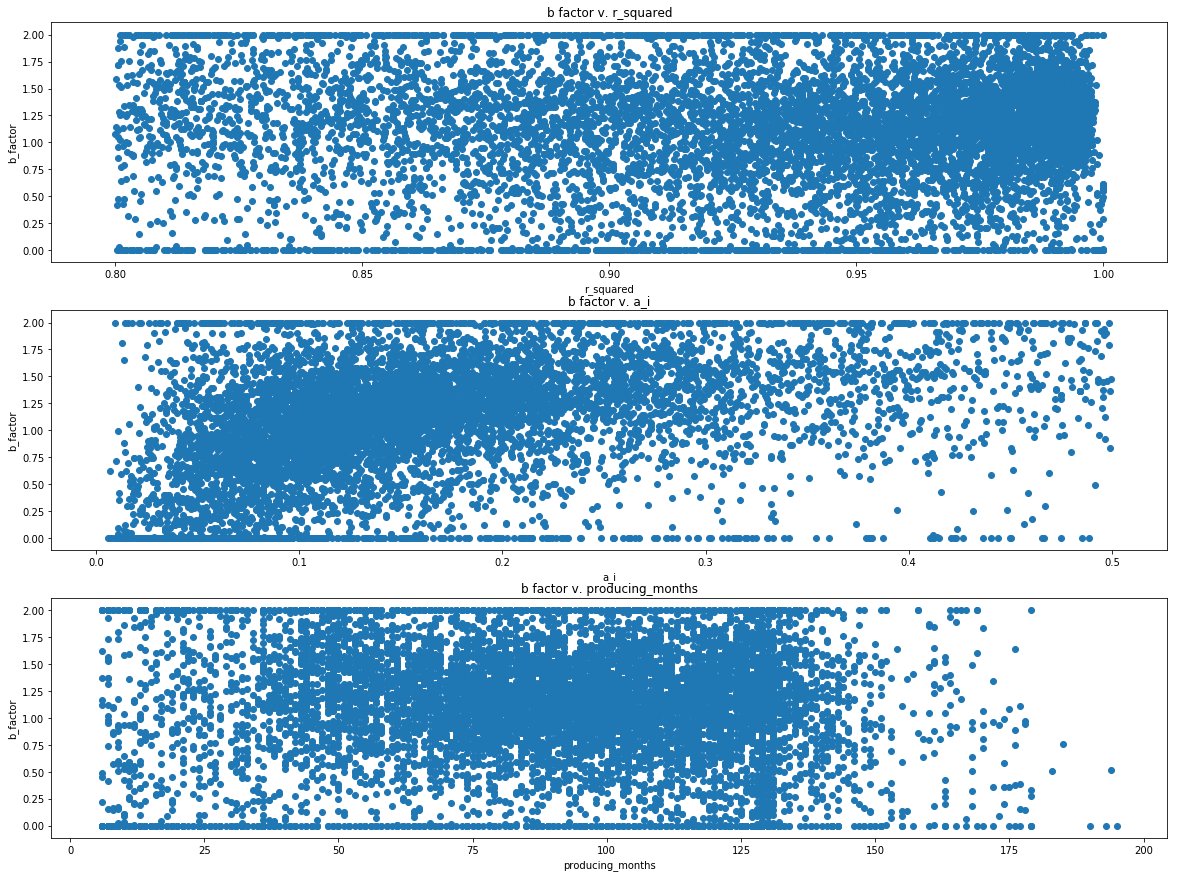

In [65]:
#looking at b factor verses different paramaters
#helps to see if there are strange behaviors
fig1 = plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
plt.scatter(output_well_data['r_squared'], output_well_data['b'])
plt.title('b factor v. r_squared')
plt.xlabel('r_squared')
plt.ylabel('b_factor')

plt.subplot(3,1,2)
plt.scatter(output_well_data['a'].loc[output_well_data['a'] < .5], output_well_data['b'].loc[output_well_data['a'] < .5])
plt.title('b factor v. a_i')
plt.xlabel('a_i')
plt.ylabel('b_factor')

plt.subplot(3,1,3)
plt.scatter(output_well_data['producing_months'].loc[output_well_data['producing_months'] < 200], output_well_data['b'].loc[output_well_data['producing_months'] < 200])
plt.title('b factor v. producing_months')
plt.xlabel('producing_months')
plt.ylabel('b_factor')

plt.show()

In [117]:
#grouping by the county, then the average values 
#interested in the average for b, r_squared, and producing months
county_b_grouped_df = output_well_data.groupby('county').mean()
county_b_grouped_df.sort_values('b', ascending=False, inplace=True)

#grouping by the county, then getting the count of wells in each county
county_count_grouped_df = output_well_data.groupby('county').count()
county_count_grouped_df = county_count_grouped_df['a']
county_b_grouped_df = county_b_grouped_df.merge(county_count_grouped_df, left_index=True, right_index=True)

print(county_b_grouped_df.columns.tolist())

#dropping the average of a_i, renaming the last column to count of wells in the county
county_b_grouped_df.drop('a_x', inplace=True, axis=1)
county_b_grouped_df.rename({'a_y':'well_count'}, inplace=True, axis=1)

#dropping all the counties with less than 10 wells
county_b_grouped_df = county_b_grouped_df.loc[county_b_grouped_df['well_count'] >= 10]

#adding the state data 
state_data = output_well_data.groupby('county').first()
state_data = state_data['state']
county_b_grouped_df = county_b_grouped_df.merge(state_data, left_index=True, right_index=True)

#cleaning up the data by rounding off
county_b_grouped_df['b'] = county_b_grouped_df['b'].round(2)
county_b_grouped_df['r_squared'] = county_b_grouped_df['r_squared'].round(2)
county_b_grouped_df['producing_months'] = county_b_grouped_df['producing_months'].astype('int')

print(county_b_grouped_df.head(10))
print(county_b_grouped_df.tail(10))

['a_x', 'b', 'r_squared', 'producing_months', 'a_y']
                    b  r_squared  producing_months  well_count state
county                                                              
Leslie           1.49       0.84                87          21    KY
Atoka            1.40       0.93               110          44    OK
Harlan           1.39       0.87                70          27    KY
Lamar            1.34       0.96                97          25    MS
Jefferson Davis  1.31       0.97               118          26    MS
Hughes           1.30       0.92                83         288    OK
Perry            1.29       0.85                94          58    KY
Blaine           1.29       0.92                66          39    OK
Coal             1.28       0.92                94         285    OK
Pope             1.27       0.92               102          32    AR
                 b  r_squared  producing_months  well_count state
county                                               

In [167]:
#grouping by the operator, then the average values 
#interested in the average for b, r_squared, and producing months
operator_b_grouped_df = output_well_data.groupby('operator').mean()
operator_b_grouped_df.sort_values('b', ascending=False, inplace=True)

#grouping by the county, then getting the count of wells in each county
operator_count_grouped_df = output_well_data.groupby('operator').count()
operator_count_grouped_df = operator_count_grouped_df['a']
operator_b_grouped_df = operator_b_grouped_df.merge(operator_count_grouped_df, left_index=True, right_index=True)


#dropping the average of a_i, renaming the last column to count of wells in the county
operator_b_grouped_df.drop('a_x', inplace=True, axis=1)
operator_b_grouped_df.rename({'a_y':'well_count'}, inplace=True, axis=1)

#dropping all the counties with less than 10 wells
operator_b_grouped_df = operator_b_grouped_df.loc[operator_b_grouped_df['well_count'] >= 10]

#cleaning up the data by rounding off, renaming, and dropping
operator_b_grouped_df['b'] = operator_b_grouped_df['b'].round(2)
operator_b_grouped_df['r_squared'] = operator_b_grouped_df['r_squared'].round(2)
operator_b_grouped_df.drop('producing_months', inplace=True, axis=1)
operator_b_grouped_df.rename({'b':'b_factor'}, inplace=True, axis=1)
operator_b_grouped_df.drop('r_squared', inplace=True, axis =1)
#operator_b_grouped_df['producing_months'] = operator_b_grouped_df['producing_months'].astype('int')
operator_b_grouped_df['well_count'] = operator_b_grouped_df['well_count'].round(0)

print(operator_b_grouped_df.head(20))
print(operator_b_grouped_df.tail(20).iloc[::-1])

                                  b_factor  well_count
operator                                              
Corterra Energy Operating Llc         1.66          53
Pablo Energy Ii Llc                   1.48          23
Magnum Hunter Production Inc          1.45          52
Riviera Operating Llc                 1.43         116
Fdl Operating, Llc                    1.37          33
Caerus Piceance Llc                   1.36          19
Vanguard Operating Llc                1.35          94
Marathon Oil Company                  1.32          21
Central Operating, Llc                1.32          22
Foundation Energy Management Llc      1.32          47
Cimarex Energy Co                     1.30          65
Gulf Pine Energy Operating, Llc       1.28          18
Devon Energy Production Co Lp         1.27          82
Mewbourne Oil Company                 1.27          33
Newfield Exploration Mid-con Inc      1.26         191
Xto Energy Inc                        1.25          93
Denbury On

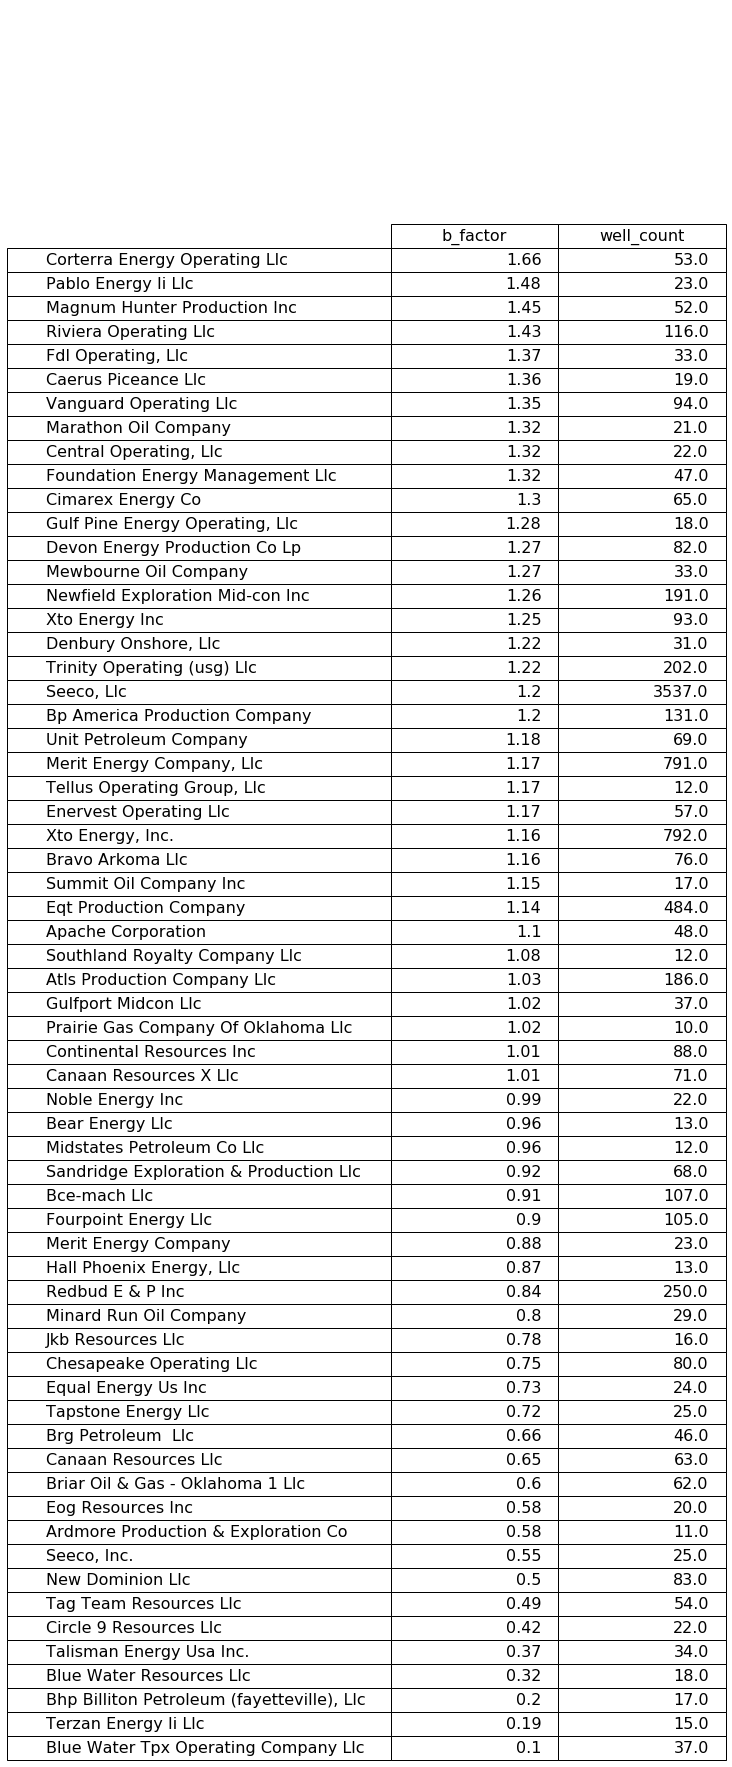

In [168]:
#making the dataframe display as a table

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

pd.plotting.table(ax, operator_b_grouped_df)

table = ax.tables[0]
table.set_fontsize(16)
table.scale(1,2)